In [16]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import json
from tools import create_x_y

In [49]:
def encode_y(y):
    if len(set(y)) == 2:
        remap_dict = {-1: 0, 1: 1}
    elif len(set(y)) == 3:
        remap_dict = {-1: 0, 0: 1, 1: 2}
    elif len(set(y)) == 5:
        remap_dict = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
    for i, val in enumerate(y):
        y[i] = remap_dict[val]

    return y

def importances_from_lag(x, col_names):
    lag = int(len(x) / len(col_names))
    len_col = len(col_names)
    imp = {
        col_names[i]: sum(x[i * lag : (i + 1) * lag]) / lag
        for i in range(len_col)
    }
    imp = dict(sorted(imp.items(), key=lambda item: item[1], reverse=True))
    return imp

In [18]:
df = pd.read_csv("../datasets/v3/binned/amzn.csv")

In [15]:
OTHER_COLS = ["open", "high", "low", "close", "vol"]
lag = 2
x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_2", lag=lag)
y = encode_y(y)

In [19]:
mode = "binary:logistic"

clf = xgb.XGBClassifier(objective=mode, random_state=42)# tree_method='gpu_hist', gpu_id=0)

params  = {
#'n_estimators': [400, 800],
#'max_depth': [3, 6, 9],
#'learning_rate': [0.05, 0.1, 0.2],
#'min_child_weight': [1, 10, 100]
}

time_split = TimeSeriesSplit(n_splits=5)
xgb_search = GridSearchCV(
    clf,
    param_grid=params,
    cv=time_split,
    verbose=1,
)
split = int(0.8 * len(x))
xgb_search.fit(x[:split], y[:split])
y_pred = xgb_search.predict(x[split:])

acc = accuracy_score(y[split:], y_pred)
f1 = f1_score(y[split:], y_pred, average="weighted")
roc = roc_auc_score(y[split:], y_pred)
fi = xgb_search.best_estimator_.feature_importances_

my_xgb = xgb_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [20]:
fi

array([0.0833834 , 0.10162395, 0.11038394, 0.09836508, 0.12088264,
       0.10688559, 0.10346754, 0.10476496, 0.08244761, 0.08779529],
      dtype=float32)

In [21]:
import shap


In [22]:
explainer = shap.TreeExplainer(my_xgb)

In [23]:
sp = explainer.shap_values(x[:split])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [24]:
sp.shape

(6894, 10)

In [25]:
sp

array([[-6.09874070e-01, -6.86175883e-01, -2.18910411e-01, ...,
         8.47570062e-01, -1.70424655e-01, -1.93595037e-01],
       [-1.37191176e-01, -6.35072291e-01, -9.16338623e-01, ...,
         9.62081850e-01,  7.16914833e-02,  1.64256971e-02],
       [-1.76072612e-01, -6.48507059e-01, -7.65417755e-01, ...,
         7.72584617e-01, -1.89698517e-01,  1.01593003e-01],
       ...,
       [-1.18085966e-01,  8.42435434e-02,  2.04023555e-01, ...,
         2.45655507e-01,  1.30320132e-01,  8.51022080e-04],
       [-3.67530853e-01,  7.46387169e-02, -9.65377018e-02, ...,
        -5.57710081e-02,  2.23827492e-02, -5.25992215e-02],
       [-2.32299343e-01,  9.66057703e-02, -1.31632343e-01, ...,
        -1.24888932e-02, -2.68256515e-01, -3.35630387e-01]], dtype=float32)

In [50]:
this = np.abs(sp).mean(axis=0)
this

array([0.18115368, 0.20160437, 0.1339371 , 0.16578591, 0.29569918,
       0.14387973, 0.17304076, 0.19480655, 0.20830432, 0.21085966],
      dtype=float32)

In [51]:
x = importances_from_lag(this, OTHER_COLS)
x

{'low': 0.21978945285081863,
 'vol': 0.20958198606967926,
 'open': 0.19137902557849884,
 'close': 0.1839236542582512,
 'high': 0.14986150711774826}

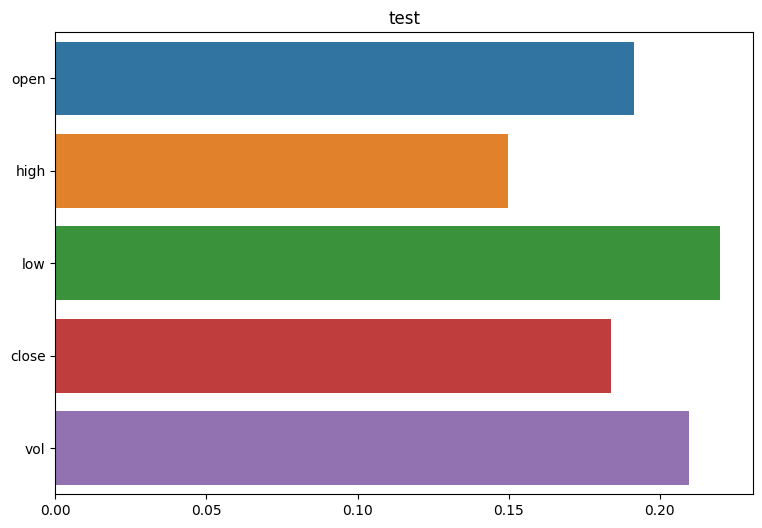

In [42]:
save_shapley_plot(sp, "test", "test", OTHER_COLS)